## Load the cleaned dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def load_data():
    
    df_train = pd.read_csv('dataset/cleaned_train.csv')
    df_test = pd.read_csv('dataset/test.csv', encoding = "ISO-8859-1")

    return df_train, df_test

In [3]:
df_train, df_test = load_data()

In [4]:
df_train.shape

(250305, 11)

In [5]:
df_train.isnull().sum()

ticket_id          0
city               0
agency_name        0
violation_code     0
disposition        0
fine_amount        0
judgment_amount    0
late_fee           0
admin_fee          0
discount_amount    0
compliance         0
dtype: int64

In [6]:
df_train.head()

,ticket_id,city,agency_name,violation_code,disposition,fine_amount,judgment_amount,late_fee,admin_fee,discount_amount,compliance
0,22056,4,1,1,1,250.0,305.0,25.0,20.0,0,0.0
1,27586,1,1,7,4,750.0,855.0,75.0,20.0,0,1.0
2,22062,1,1,1,2,250.0,0.0,0.0,0.0,0,0.0
3,22084,1,1,1,2,250.0,0.0,0.0,0.0,0,0.0
4,22093,1,1,1,2,250.0,0.0,0.0,0.0,0,0.0


In [7]:
X = df_train[df_train.columns[1:-1]]
y = df_train['compliance']

## Resampling dataset

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.kernel_approximation import RBFSampler
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, roc_curve, auc, plot_roc_curve, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV

In [9]:
df_true = df_train[df_train.compliance == 1]
df_false = df_train[df_train.compliance != 1]

count_nopay, count_paid = df_train.compliance.value_counts()
print(count_paid, count_nopay)

11597 238708


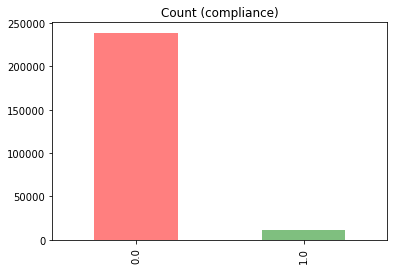

In [10]:
df_train.compliance.value_counts().plot(kind='bar', title='Count (compliance)', color=['red', 'green'], alpha=0.5);

### Random under-sesampling

Random under-sampling:
1.0    11597
0.0    11597
Name: compliance, dtype: int64


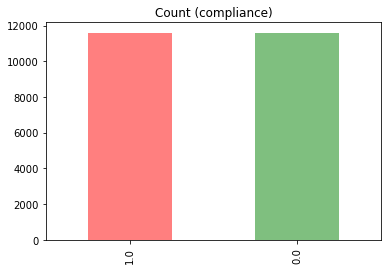

In [11]:
df_false_under = df_false.sample(count_paid)
df_train_under = pd.concat([df_false_under, df_true], axis=0)

print('Random under-sampling:')
print(df_train_under.compliance.value_counts())

df_train_under.compliance.value_counts().plot(kind='bar', title='Count (compliance)', color=['red', 'green'], alpha=0.5);

### Random over-sesampling

Random under-sampling:
1.0    238708
0.0    238708
Name: compliance, dtype: int64


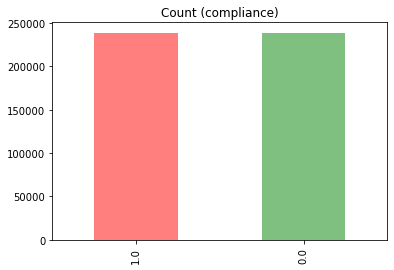

In [12]:
df_train_over = pd.concat([df_false, df_true.sample(count_nopay, replace=True)], axis=0)

print('Random under-sampling:')
print(df_train_over.compliance.value_counts())

df_train_over.compliance.value_counts().plot(kind='bar', title='Count (compliance)', color=['red', 'green'], alpha=0.5);

### Python imblanced-learn module

In [13]:
import imblearn
print(imblearn.__version__)

0.7.0


### Random over-sampling and under-sampling with imbalanced-learn

In [14]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_ros, y_ros = ros.fit_sample(X, y)

In [15]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_rus, y_rus = rus.fit_sample(X, y)

### Under-sampling: NearMiss, Edited Nearest Neighbours, OneSidedSelection, Neighbourhood Cleaning Rule

In [16]:
from imblearn.under_sampling import NearMiss

undersample = NearMiss(version=1, n_neighbors=3)
X_nm1, y_nm1 = undersample.fit_resample(X, y)

In [17]:
from imblearn.under_sampling import EditedNearestNeighbours

undersample = EditedNearestNeighbours(n_neighbors=3)
X_enn, y_enn = undersample.fit_resample(X, y)

In [18]:
from imblearn.under_sampling import OneSidedSelection

undersample = OneSidedSelection(n_neighbors=1, n_seeds_S=200)
X_oss, y_oss = undersample.fit_resample(X, y)

In [19]:
from imblearn.under_sampling import NeighbourhoodCleaningRule

undersample = NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)
X_ncr, y_ncr = undersample.fit_resample(X, y)

### Over-sampling: SMOTE

In [20]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority', random_state=0)
X_sm, y_sm = smote.fit_sample(X, y)

### Over-sampling followed by under-sampling: STMOTE and Tomek

In [21]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy='auto', random_state=0)
X_smt, y_smt = smt.fit_sample(X, y)

### Ready for training

In [22]:
def modelFit(X_train, X_dev, y_train, y_dev, clf, cv=5):

    clf = clf.fit(X_train, y_train)

    cv = cross_val_score(clf, X_dev, y_dev, cv=cv, scoring = 'roc_auc')
    cv_mean = round(cv.mean(), 3)
    cv_std = round(cv.std(), 3)
    print('Cross-validation (AUC)', cv, ', mean =', cv_mean, ', std =', cv_std)

    return cv_mean, cv_std

In [23]:
X_train, X_dev, y_train, y_dev = train_test_split(X, y, random_state=0, test_size=0.05)
X_train_rus, X_dev_rus, y_train_rus, y_dev_rus = train_test_split(X_rus, y_rus, random_state=0, test_size=0.05)
X_train_ros, X_dev_ros, y_train_ros, y_dev_ros = train_test_split(X_ros, y_ros, random_state=0, test_size=0.05)
X_train_nm1, X_dev_nm1, y_train_nm1, y_dev_nm1 = train_test_split(X_nm1, y_nm1, random_state=0, test_size=0.05)
X_train_enn, X_dev_enn, y_train_enn, y_dev_enn = train_test_split(X_enn, y_enn, random_state=0, test_size=0.05)
X_train_oss, X_dev_oss, y_train_oss, y_dev_oss = train_test_split(X_oss, y_oss, random_state=0, test_size=0.05)
X_train_ncr, X_dev_ncr, y_train_ncr, y_dev_ncr = train_test_split(X_ncr, y_ncr, random_state=0, test_size=0.05)
X_train_sm, X_dev_sm, y_train_sm, y_dev_sm = train_test_split(X_sm, y_sm, random_state=0, test_size=0.05)
X_train_smt, X_dev_smt, y_train_smt, y_dev_smt = train_test_split(X_smt, y_smt, random_state=0, test_size=0.05)

In [24]:
clf_XGB = XGBClassifier()

In [25]:
#exp0: no resampling
auc_mean_baseline, auc_std_baseline = modelFit(X_train, X_dev, y_train, y_dev, clf_XGB, cv=50)

Cross-validation (AUC) [0.78506787 0.94602456 0.85374919 0.91531997 0.89964447 0.92792502
 0.84954751 0.90239173 0.86829347 0.81011635 0.91758242 0.87039431
 0.94974144 0.92275372 0.93148028 0.86732385 0.83823529 0.93977591
 0.83648459 0.89898459 0.79604342 0.90651261 0.94205182 0.90738796
 0.85119048 0.87044818 0.86537115 0.90581232 0.87009804 0.81932773
 0.82072829 0.84348739 0.89653361 0.87710084 0.83946078 0.85661765
 0.93890056 0.80357143 0.73686975 0.83315826 0.8644958  0.88655462
 0.91088936 0.7797619  0.83315826 0.86309524 0.87482493 0.92769608
 0.92064265 0.82083739] , mean = 0.872 , std = 0.049


In [26]:
#exp1
auc_mean_ros, auc_std_ros = modelFit(X_train_ros, X_dev_ros, y_train_ros, y_dev_ros, clf_XGB, cv=50)

Cross-validation (AUC) [0.86616944 0.87533484 0.88984015 0.88672374 0.90533466 0.86743877
 0.88198785 0.85754679 0.88053469 0.87761087 0.89592416 0.87809234
 0.8978938  0.88391372 0.88014952 0.87024879 0.86206383 0.88166395
 0.87286622 0.88558573 0.88290702 0.88263064 0.91168507 0.86176067
 0.86558478 0.87674063 0.87892932 0.8896185  0.90262834 0.8891526
 0.90636428 0.89766174 0.8927391  0.85693565 0.89302918 0.86849508
 0.89047117 0.87744374 0.89592124 0.8715102  0.88829993 0.88289381
 0.8664557  0.85425457 0.88578586 0.87247714 0.90170534 0.89694972
 0.87755802 0.88306083] , mean = 0.882 , std = 0.013


In [27]:
#exp2
auc_mean_rus, auc_std_rus = modelFit(X_train_rus, X_dev_rus, y_train_rus, y_dev_rus, clf_XGB, cv=50)

Cross-validation (AUC) [0.89583333 0.79861111 0.84375    0.85416667 0.83680556 0.95138889
 0.88194444 0.85416667 0.87152778 0.82986111 0.78030303 0.95833333
 1.         0.90530303 0.86742424 0.88636364 0.80681818 0.70833333
 0.82575758 0.83333333 0.88636364 0.80681818 0.92045455 0.86363636
 0.90909091 0.82954545 0.78409091 0.95454545 0.81060606 0.96212121
 0.91666667 0.85984848 0.96212121 0.84090909 0.79545455 0.82575758
 0.88257576 0.85606061 0.80681818 0.97348485 0.8030303  0.88257576
 0.92045455 0.87121212 0.90530303 0.78030303 0.89015152 0.65530303
 0.91666667 0.85227273] , mean = 0.862 , std = 0.066


In [28]:
#exp3
auc_mean_nm1, auc_std_nm1 = modelFit(X_train_nm1, X_dev_nm1, y_train_nm1, y_dev_nm1, clf_XGB, cv=50)

Cross-validation (AUC) [0.8125     0.73263889 0.85069444 0.82638889 0.79513889 0.84375
 0.87847222 0.75       0.84722222 0.71180556 0.70454545 0.9469697
 0.95454545 0.85984848 0.78030303 0.66666667 0.59848485 0.59469697
 0.86363636 0.84469697 0.71969697 0.8219697  0.83333333 0.64393939
 0.875      0.73863636 0.86742424 0.85606061 0.68181818 0.87878788
 0.92424242 0.83333333 0.9280303  0.83712121 0.77651515 0.75378788
 0.85984848 0.83333333 0.74242424 0.82954545 0.79545455 0.78787879
 0.81060606 0.94318182 0.90530303 0.77651515 0.84848485 0.67045455
 0.72727273 0.92045455] , mean = 0.806 , std = 0.087


In [29]:
#exp4
auc_mean_enn, auc_std_enn = modelFit(X_train_enn, X_dev_enn, y_train_enn, y_dev_enn, clf_XGB, cv=50)

Cross-validation (AUC) [0.90176648 0.9133994  0.86018957 0.91059888 0.87419216 0.91770788
 0.96359328 0.82744507 0.955838   0.84058595 0.89250323 0.83261525
 0.90068936 0.85114175 0.84206349 0.85396825 0.82777778 0.95873016
 0.9468254  0.88492063 0.95297619 0.90436508 0.93710317 0.90119048
 0.94980159 0.96686508 0.88095238 0.92857143 0.92083333 0.9422619
 0.94960317 0.95039683 0.92638889 0.90595238 0.90753968 0.93373016
 0.92956349 0.925      0.84880952 0.90198413 0.86924603 0.96587302
 0.90674603 0.83412698 0.87460317 0.81309524 0.91190476 0.89069264
 0.87554113 0.86320346] , mean = 0.901 , std = 0.042


In [30]:
#exp5
auc_mean_oss, auc_std_oss = modelFit(X_train_oss, X_dev_oss, y_train_oss, y_dev_oss, clf_XGB, cv=50)

Cross-validation (AUC) [0.79389313 0.86545802 0.85305344 0.78594148 0.7274173  0.82283715
 0.72550891 0.9153944  0.79484733 0.92048346 0.92525445 0.77735369
 0.81743003 0.86577608 0.88549618 0.79103053 0.69688295 0.83237913
 0.81065089 0.65384615 0.7591716  0.85650888 0.61715976 0.86627219
 0.97337278 0.76272189 0.86153846 0.81745562 0.87337278 0.73994083
 0.85192308 0.68910256 0.75352564 0.77339744 0.9025641  0.74358974
 0.78621795 0.89230769 0.90288462 0.78173077 0.85929487 0.73974359
 0.84038462 0.9025641  0.76410256 0.84551282 0.74903846 0.66602564
 0.88044872 0.92435897] , mean = 0.813 , std = 0.078


In [31]:
#exp6
auc_mean_ncr, auc_std_ncr = modelFit(X_train_ncr, X_dev_ncr, y_train_ncr, y_dev_ncr, clf_XGB, cv=50)

Cross-validation (AUC) [0.90049656 0.79411765 0.91424752 0.85618793 0.85064935 0.89362108
 0.91100076 0.85064935 0.82830405 0.80901451 0.9394576  0.84110008
 0.83537051 0.95187166 0.88846448 0.91787624 0.87851617 0.85232068
 0.81549674 0.96854622 0.84656694 0.85788262 0.87015727 0.86996548
 0.9357499  0.9556962  0.95723053 0.75968546 0.89835059 0.91004987
 0.88013042 0.93210587 0.96279248 0.83160721 0.90180284 0.8273878
 0.78289221 0.83007288 0.787687   0.9336402  0.86651323 0.94553126
 0.82796318 0.78365938 0.73283468 0.86766398 0.89873418 0.83966245
 0.89240506 0.79919448] , mean = 0.87 , std = 0.056


In [32]:
#exp7
auc_mean_sm, auc_std_sm = modelFit(X_train_sm, X_dev_sm, y_train_sm, y_dev_sm, clf_XGB, cv=50)

Cross-validation (AUC) [0.83555684 0.89544269 0.86947844 0.8722622  0.89763993 0.87059019
 0.87294501 0.84279637 0.87926537 0.8826444  0.90756692 0.86768388
 0.89590665 0.88063099 0.87252482 0.88604969 0.87338271 0.88853581
 0.85548086 0.88689882 0.89995098 0.84734334 0.90224348 0.86868802
 0.8531806  0.87184401 0.86729958 0.90259318 0.90822785 0.87732947
 0.91559423 0.90630274 0.88056435 0.86622714 0.88017757 0.90332278
 0.88151371 0.87116737 0.89403129 0.86692159 0.88388713 0.88582103
 0.86964662 0.86894339 0.90289205 0.86356364 0.89318741 0.88780767
 0.8968794  0.88998769] , mean = 0.881 , std = 0.018


In [33]:
#exp8
auc_mean_smt, auc_std_smt = modelFit(X_train_smt, X_dev_smt, y_train_smt, y_dev_smt, clf_XGB, cv=50)

Cross-validation (AUC) [0.88035789 0.87031622 0.85213265 0.88279171 0.88002521 0.86195546
 0.87470234 0.89290342 0.89387519 0.83683814 0.88985677 0.87620815
 0.8517562  0.8707452  0.86540482 0.8913976  0.89767474 0.88439382
 0.88247654 0.88928772 0.89505708 0.87476264 0.88260426 0.90417751
 0.89087664 0.87412089 0.8957381  0.88444159 0.89986989 0.89080632
 0.87573845 0.87989662 0.86870561 0.85470146 0.87106161 0.86742211
 0.88801955 0.87722414 0.86884122 0.86533322 0.89445226 0.86306488
 0.87866186 0.89925268 0.87002813 0.90883594 0.84830315 0.87180411
 0.86144716 0.86805873] , mean = 0.878 , std = 0.015


### Summary plot

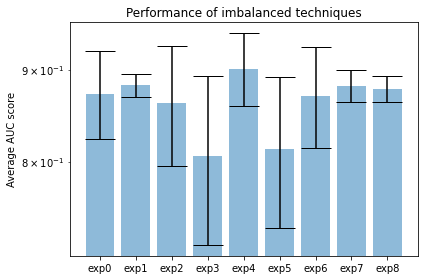

In [34]:
# Create lists for the plot
#exps = ['Baseline', 'RandomUnderSampler', 'RandomOverSampler', NearMiss', 'EditedNearestNeighbours', 'OneSidedSelection', 
#        'NeighbourhoodCleaningRule', 'SMOTE', 'STMOTE + Tomek']
exps = ['exp0','exp1','exp2','exp3','exp4','exp5','exp6','exp7','exp8']
x_pos = np.arange(len(exps))
CTEs = [auc_mean_baseline,auc_mean_ros,auc_mean_rus,auc_mean_nm1,auc_mean_enn,auc_mean_oss,auc_mean_ncr,auc_mean_sm,auc_mean_smt]
error = [auc_std_baseline,auc_std_ros ,auc_std_rus ,auc_std_nm1 ,auc_std_enn ,auc_std_oss ,auc_std_ncr ,auc_std_sm ,auc_std_smt]

# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=15)
ax.set_ylabel('Average AUC score')
ax.set_xticks(x_pos)
ax.set_xticklabels(exps)
ax.set_title('Performance of imbalanced techniques')
ax.yaxis.grid(True)
ax.set_yscale('log')

# Save the figure and show
plt.tight_layout()
plt.savefig('plots/imbalancedExp_cv.png')
plt.show()